In [2]:
from network_evaluation_tools import gene_conversion_tools as gct
import pandas as pd
import itertools
import matplotlib.pyplot as plt

In [1]:
wd = '/cellar/users/snwright/Data/Network_Analysis/'

# Version 2
## Load BioPlex Raw Data
#### Source: https://bioplex.hms.harvard.edu/data/BioPlex_293T_Network_10K_Dec_2019.tsv; https://bioplex.hms.harvard.edu/data/BioPlex_HCT116_Network_5.5K_Dec_2019.tsv
Downloaded: November 16, 2021   
Last Updated: December, 2019  
This latest update of BioPlex is associated with the recent paper: Huttlin et al. 2021 https://doi.org/10.1101/2020.01.19.905109.   

**Note:** In addition to additional data from 293T cells (v3.0), there is also published data from HCT116 cells (v1.0). These two datasets are merged.  
**Note:** We could use the 'pInt' column as a scoring metric to filter the network further, but we have chosen not to for consistency with the original PCNet publication. 

In [12]:
BioPlex_293T_Raw = pd.read_csv(wd+'Network_Data_Raw/BioPlex_293T_Network_10K_Dec_2019.tsv',sep='\t')
BioPlex_HCT116_Raw = pd.read_csv(wd+'Network_Data_Raw/BioPlex_HCT116_Network_5.5K_Dec_2019.tsv',sep='\t')
print('Raw edge count in BioPlex (293T):', len(BioPlex_293T_Raw))
print('Raw edge count in BioPlex (HCT116):', len(BioPlex_HCT116_Raw))

Raw edge count in BioPlex (293T): 118162
Raw edge count in BioPlex (HCT116): 70966


In [17]:
## Combine the two datasets. Where edges exist in both cell lines, keep the row with the lowest pInt
BioPlex_Raw_v2 = pd.concat([BioPlex_293T_Raw, BioPlex_HCT116_Raw])
print('Concatenated list of edges:', BioPlex_Raw_v2.shape)
BioPlex_Raw_v2.sort_values(by="pInt", inplace=True)
BioPlex_Raw_v2 = BioPlex_Raw_v2.drop_duplicates(subset=["GeneA", "GeneB", "UniprotA", "UniprotB", "SymbolA", "SymbolB"], keep='first')
print('After duplicate edges removed:', BioPlex_Raw_v2.shape)

Concatenated list of edges: (189128, 9)
After duplicate edges removed: (173972, 9)


In [18]:
# Convert table of interactions to edgelist (no scores given)
# Also no gene symbol conversion necessary because network is given in symbol format already
BioPlex_edgelist_v2 = BioPlex_Raw_v2[['SymbolA', 'SymbolB']].values.tolist()
print('Edges in BIND:', len(BioPlex_edgelist_v2))

Edges in BIND: 173972


In [19]:
# Sort each edge representation for filtering
BioPlex_edgelist_sorted_v2 = [sorted(edge) for edge in BioPlex_edgelist_v2]
BioPlex_edgelist_sorted_v2 = pd.DataFrame(BioPlex_edgelist_sorted_v2, columns=["symbol_n1", "symbol_n2"])

In [20]:
# Filter edgelist for duplicate nodes and for self-edges
BioPlex_edgelist_filt_v2 = gct.filter_converted_edgelist(BioPlex_edgelist_sorted_v2)

173972 input edges
0 self-edges removed
0 edges with un-mapped genes removed
6573 duplicate edges removed
Edge list filtered: 0.06 seconds
167399 Edges remaining


In [21]:
# Write network to file
gct.write_edgelist(BioPlex_edgelist_filt_v2, wd+'Processed_Data/Network_SIFs_Symbol/BioPlex_Symbol_2019.sif', binary=True)

Edge list saved: 0.16 seconds


# Version 1
## Load BioPlex Raw Data
#### Source: http://bioplex.hms.harvard.edu/data/BioPlex_interactionList_v4a.tsv
Downloaded: June 20, 2017  
Last Updated: December 01, 2016     
This latest update of BioPlex (2.0 v4) is associated with the recent paper: Huttlin et al. (2017) Nature doi: 10.1038/nature22366  
Note: We could use the 'p(Interaction)' column as a scoring metric to filter the network further, however, a top 10% filtering of this network would yield a network with <6000 interactions, so we did not feel like it was necessary to filter the network further for analysis.

In [3]:
BioPlex_Raw = pd.read_csv(wd+'Network_Data_Raw/BioPlex_interactionList_v4a.tsv',sep='\t')
print('Raw edge count in BioPlex:', len(BioPlex_Raw))

Raw edge count in BioPlex: 56553


In [4]:
BioPlex_Raw.head()

,GeneA,GeneB,UniprotA,UniprotB,SymbolA,SymbolB,p(Wrong),p(No Interaction),p(Interaction)
0,100,728378,P00813,A5A3E0,ADA,POTEF,2.380858e-09,0.000332,0.999668
1,100,345651,P00813,Q562R1,ADA,ACTBL2,9.786437e-18,0.211914,0.788086
2,222389,708,Q8N7W2,Q07021,BEND7,C1QBP,2.962215e-17,0.005645,0.994355
3,222389,4038,Q8N7W2,O75096,BEND7,LRP4,3.302994e-10,0.000280,0.999720
4,645121,3312,Q6ZMN8,P11142,CCNI2,HSPA8,2.060285e-16,0.036235,0.963765


In [5]:
# Convert table of interactions to edgelist (no scores given)
# Also no gene symbol conversion necessary because network is given in symbol format already
BioPlex_edgelist = BioPlex_Raw[['SymbolA', 'SymbolB']].values.tolist()
print('Edges in BIND:', len(BioPlex_edgelist))

Edges in BIND: 56553


In [8]:
# Sort each edge representation for filtering
BioPlex_edgelist_sorted = [sorted(edge) for edge in BioPlex_edgelist]
BioPlex_edgelist_sorted = pd.DataFrame(BioPlex_edgelist_sorted, columns=["symbol_n1", "symbol_n2"])

In [10]:
# Filter edgelist for duplicate nodes and for self-edges
BioPlex_edgelist_filt = gct.filter_converted_edgelist(BioPlex_edgelist_sorted)

56553 input edges
0 self-edges removed
0 edges with un-mapped genes removed
0 duplicate edges removed
Edge list filtered: 0.03 seconds
56553 Edges remaining


In [11]:
# Write network to file
gct.write_edgelist(BioPlex_edgelist_filt, wd+'Processed_Data/Network_SIFs_Symbol/BioPlex_Symbol_v4a_2016.sif', binary=True)

Edge list saved: 0.07 seconds


# Changes

In [22]:
stats = pd.DataFrame({"v1":[118162, 70966, 173972, 167399], 
                           "v2":[56553, 0, 56533, 56553]},
                           index=["293T input", "HCT116 input", "Total input", "Filtered"])

In [23]:
nodes_v1 = set(BioPlex_edgelist_filt["symbol_n1"].values).union(set(BioPlex_edgelist_filt["symbol_n2"].values))
nodes_v2 = set(BioPlex_edgelist_filt_v2["symbol_n1"].values).union(set(BioPlex_edgelist_filt_v2["symbol_n2"].values))

Text(0, 0.5, 'Number of nodes')

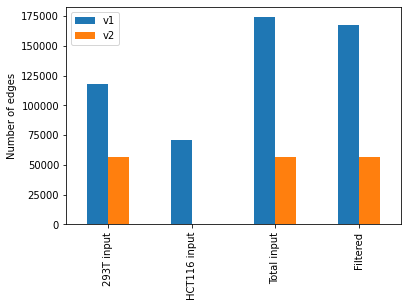

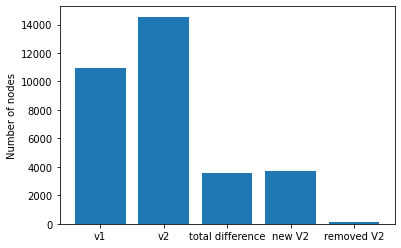

In [24]:
stats.plot.bar(ylabel="Number of edges")
plt.figure()
plt.bar(["v1", "v2", "total difference", "new V2", "removed V2"], [len(nodes_v1), len(nodes_v2), len(nodes_v2)-len(nodes_v1),
                                                           len(nodes_v2.difference(nodes_v1)), len(nodes_v1.difference(nodes_v2))])
plt.ylabel("Number of nodes")